Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B

In [2]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import scipy.stats as st

In [8]:
import os
print(os.getcwd())

c:\Users\akopeikina\OneDrive\Desktop\Statistiks\ABtesting


In [12]:
df = pd.read_csv('ab_stats.csv')

In [13]:
df

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
...,...,...,...,...,...
23647,0.0,0,0,B,10.207152
23648,0.0,0,0,B,5.148761
23649,0.0,0,0,B,4.809019
23650,0.0,0,0,B,8.127488


In [14]:
df.isna().sum()

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [17]:
import numpy as np

In [21]:
df = df.astype({'num_purchases':np.uint8})

In [48]:
df.describe(include='all')

,revenue,num_purchases,purchase,ab_group,av_site visit
count,23184.000000,23184.000000,23184.000000,23184,23184.000000
unique,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,A,NaN
freq,NaN,NaN,NaN,11829,NaN
mean,0.326511,0.043780,0.020704,NaN,7.188254
std,9.645839,1.089462,0.142394,NaN,2.924011
min,0.000000,0.000000,0.000000,NaN,0.008679
25%,0.000000,0.000000,0.000000,NaN,5.314379
50%,0.000000,0.000000,0.000000,NaN,7.068656
75%,0.000000,0.000000,0.000000,NaN,8.910900


In [31]:

# Удаление строк с нулевыми значениями и проверка на дубликаты
duplicates = df[(df['revenue'] != 0) & (df['purchase'] != 0) & (df['num_purchases'] != 0)].duplicated(subset=['revenue', 'purchase', 'num_purchases'])

# Выведем только строки с дубликатами по трём столбцам 
print(df[(df['revenue'] != 0) & (df['purchase'] != 0) & (df['num_purchases'] != 0)][duplicates])

         revenue  num_purchases  purchase ab_group  av_site visit
615     4.990000              1         1        A       8.489661
1276    1.990000              1         1        A       7.135735
1500    1.990000              1         1        A       7.375742
1962    1.990000              1         1        A      11.436115
2054    4.990000              1         1        A       4.394339
...          ...            ...       ...      ...            ...
22787   1.990000              1         1        B       6.354351
22835   1.990000              1         1        B       3.568086
22960   3.990000              1         1        B       5.960457
23584  19.990000              1         1        B       9.813696
23616   2.453401              1         1        B      11.909353

[116 rows x 5 columns]


In [43]:
from scipy.stats import shapiro

# Предположим, что df - это ваш DataFrame

# Список столбцов, которые вы хотите проверить на нормальность
columns_to_check = ['revenue', 'purchase', 'num_purchases']

for column in columns_to_check:
    # Проведение теста Шапиро-Уилка
    stat, p_value = shapiro(df[column])

    # Вывод результатов теста для каждого столбца
    print(f"Столбец '{column}':")
    print(f"  Статистика теста: {stat}")
    print(f"  P-значение теста: {p_value}")

    # Принятие решения на основе уровня значимости (обычно 0.05)
    if p_value < 0.05:
        print(f"  Распределение данных в столбце '{column}' не является нормальным.")
    else:
        print(f"  Распределение данных в столбце '{column}' может быть нормальным.")
    print()


Столбец 'revenue':
  Статистика теста: 0.011580824851989746
  P-значение теста: 0.0
  Распределение данных в столбце 'revenue' не является нормальным.

Столбец 'purchase':
  Статистика теста: 0.12259548902511597
  P-значение теста: 0.0
  Распределение данных в столбце 'purchase' не является нормальным.

Столбец 'num_purchases':
  Статистика теста: 0.014115571975708008
  P-значение теста: 0.0
  Распределение данных в столбце 'num_purchases' не является нормальным.



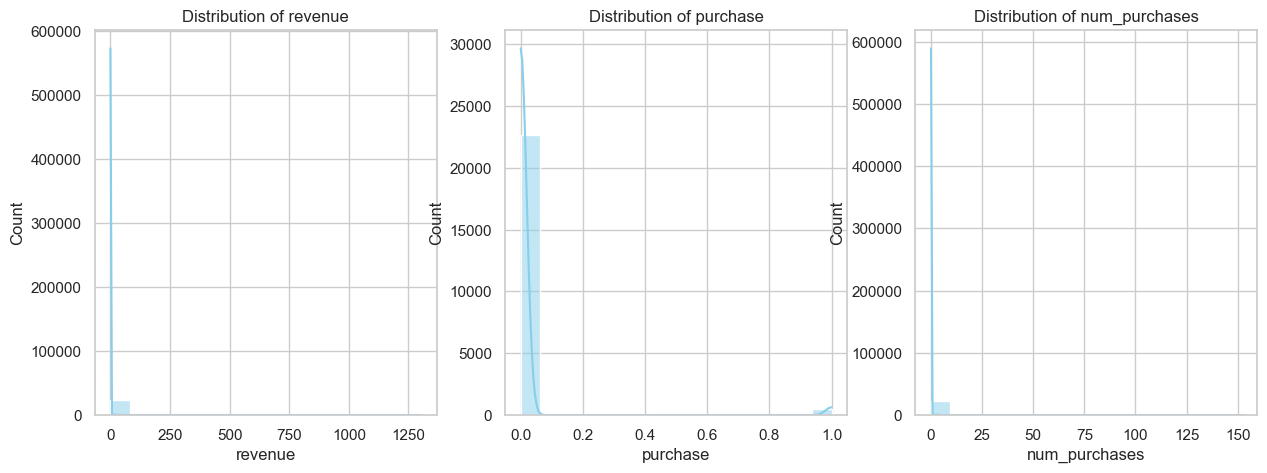

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
columns_to_visualize = ['revenue', 'purchase', 'num_purchases']
# Устанавливаем стиль seaborn для более красивых графиков
sns.set(style="whitegrid")
# Создаем фигуру с тремя подграфиками
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_visualize), figsize=(15, 5))

for i, column in enumerate(columns_to_visualize):
    sns.histplot(df[column], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {column}')

plt.show()

In [36]:
from scipy.stats import ttest_1samp
# Проверка наличия отрицательных значений в столбцах 'revenue' и 'av_site visit'
negative_values_revenue = df['revenue'] < 0
negative_values_av_site_visit = df['av_site visit'] < 0
# Выведем строки с отрицательными значениями в столбцах 'revenue' и 'av_site visit'
print(df[negative_values_revenue | negative_values_av_site_visit])
# Проведение t-теста для среднего значения в столбце 'revenue'
t_stat_revenue, p_value_revenue = ttest_1samp(df['revenue'], 0)
# Проведение t-теста для среднего значения в столбце 'av_site visit'
t_stat_av_site_visit, p_value_av_site_visit = ttest_1samp(df['av_site visit'], 0)
print(f"T-статистика для 'revenue': {t_stat_revenue}, P-значение: {p_value_revenue}")
print(f"T-статистика для 'av_site visit': {t_stat_av_site_visit}, P-значение: {p_value_av_site_visit}")

if p_value_revenue < 0.05 or p_value_av_site_visit < 0.05:
    print("Отрицательные значения в 'revenue' или 'av_site visit' статистически значимы.")
    # Удаление строк с отрицательными значениями в 'revenue' или 'av_site visit'
    df = df[~(negative_values_revenue | negative_values_av_site_visit)]
else:
    print("Отрицательные значения в 'revenue' и 'av_site visit' не являются статистически значимыми.")

       revenue  num_purchases  purchase ab_group  av_site visit
1789       0.0              0         0        A     -12.073486
1856       0.0              0         0        A      -0.683411
5122       0.0              0         0        A      -0.045455
7109       0.0              0         0        A     -12.073486
8118       0.0              0         0        A      -0.126946
...        ...            ...       ...      ...            ...
23567      0.0              0         0        B      -3.901748
23606      0.0              0         0        B      -2.284448
23626      0.0              0         0        B      -3.528928
23634      0.0              0         0        B      -1.708265
23635      0.0              0         0        B      -0.367416

[468 rows x 5 columns]
T-статистика для 'revenue': 5.224524097475803, P-значение: 1.7608312830929852e-07
T-статистика для 'av_site visit': 341.902760495354, P-значение: 0.0
Отрицательные значения в 'revenue' или 'av_site visit' ста

In [40]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from decimal import Decimal, getcontext
total_rows = len(df)
# Количество дубликатов
duplicates_count = df.duplicated().sum()
expected_duplicates = total_rows * (1 / 2)
# Выполнение Z-теста для доли
z_stat, p_value = proportions_ztest(duplicates_count, total_rows, expected_duplicates)
getcontext().prec = 50
print(f"Z-статистика: {z_stat:.5f}")
print(f"p-value: {p_value:.30f}")
print()
# Принятие решения на основе уровня значимости
if p_value < Decimal('0.05'):
    print("Результат статистически значим, можно рассмотреть удаление дубликатов.")
else:
    print("Результат не является статистически значимым.")

Z-статистика: -4846107.03793
p-value: 0.000000000000000000000000000000

Результат статистически значим, можно рассмотреть удаление дубликатов.


В данном случае некорректность информации не позволяет провести статистическую обработку данных и сделать однозначный вывод на основании этого анализа; Уточнение данных из источника или проведение дополнительного сбора данных является желательным.